In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
from sklearn import preprocessing
from sklearn.impute import KNNImputer

Load data

In [63]:
connections_df = pd.read_csv('data/connections.csv',delimiter='\t', on_bad_lines='skip')
processes_df = pd.read_csv('data/processes.csv',delimiter='\t', on_bad_lines='skip')
profiles_df = pd.read_csv('data/profiles.csv',delimiter='\t', on_bad_lines='skip')
devices_df = pd.read_csv('data/devices.csv',delimiter='\t', on_bad_lines='skip')

1) Data description
A) Analyze data structures

In [ ]:
c1 = connections_df.columns
c2 = processes_df.columns
c3 = profiles_df.columns
c4 = devices_df.columns

print("connections :", c1)
print("processes :", c2)
print("profiles :", c3)
print("devices :", c4)

From this output we can see names of the columns in our datasets - which suggests that the important datasets will be processes and connections. Profiles and devices will be less useful, since we are trying to predict mwra, we do not care in which store the device was bought or what is the owners job, birthdate... .

In [ ]:
print("\nSummary for connections:")
print(connections_df.describe())
print("\nSummary for processes:")
print(processes_df.describe())
print("\nSummary for profiles:")
print(profiles_df.describe())
print("\nSummary for devices:")
print(devices_df.describe())

From this output we can see that a summary statistics for the datasets. 
The IMEI indicates an ID of the device.
The columns in the connections dataset seem consistent.
The columns in the processes dataset suggest higher standard deviation.

In [ ]:
print("\nSummary for profiles:")
print(profiles_df.describe(exclude=np.number))
print("\nSummary for devices:")
print(devices_df.describe(exclude=np.number))

The result of profiles and devices description does not suggest that the data could be relevant to mwra

In [ ]:
print("\nInfo for connections:")
print(connections_df.info())
print("\nInfo for processes:")
print(processes_df.info())
print("\nInfo for profiles:")
print(profiles_df.info())
print("\nInfo for devices:")
print(devices_df.info())

This output provides us with information about the datasets, like the amount of non null records or variable types.
We can see that the profiles and devices contain mostly object-like data, and connections and processes contain mostly floats.
Other than that we acn also see that the more important data to us (processes and connections) do not contain missing values.

In [ ]:
#Combine datasets
combined_df = connections_df.merge(processes_df, on='imei', how='inner')\
                            .merge(profiles_df, on='imei', how='inner')\
                            .merge(devices_df, on='imei', how='inner')
combined_df = combined_df.drop_duplicates()
print(combined_df.shape)

#Combine datasets in a more controlled manner
process_devices_df = processes_df.merge(devices_df, on='imei', how='inner')
connection_profiles_df = connections_df.merge(profiles_df, on='imei', how='inner')

Here we attempt to join the datasets, which does not result in anything useful, since there are multiple records of the same imei in some datasets.

By joining the datasets in a more controlled manner we may be able to extract correletions between mwra and more personal information like location, age or profession.

B) Attribute Analysis

In [16]:
selected_attributes_connections = ['c.android.youtube', 'c.android.gm', 'c.android.chrome', 'c.katana', 'c.updateassist'] 
selected_attributes_processes = ['p.android.settings', 'p.android.packageinstaller', 'p.android.gm', 'p.system', 'p.android.externalstorage']

In [17]:
def plot_and_describe(df, attributes):
        for attribute in attributes:
            sns.histplot(df[attribute], kde=True)
            plt.title(f'Distribution of {attribute}')
            plt.show()
            print(f'Descriptive statistics for {attribute}:')
            print(df[attribute].describe())

In [ ]:
plot_and_describe(connections_df, selected_attributes_connections)
plot_and_describe(processes_df, selected_attributes_processes)

We chose the selected attributes based on the correlation matrix (used later), using ones that have high correlation with MWRA.
From the resulted graphs for connections, we can see that the output is often normally distributed, which suggests a low amount of extremes and not a lot of skewness.

From the resulted graphs for processes, we can see more normal distribution, suggesting that the data is distributed around the mean. This shows a fewer extremes and consistent behavior.

C) Pair analysis

In [19]:
connections_numeric_df = connections_df.select_dtypes(include=[np.number])
processes_numeric_df = processes_df.select_dtypes(include=[np.number])

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(connections_numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title("Correlation Heatmap for Connections Dataset")
plt.show()

In [ ]:
columns_to_exclude = ['c.UCMobile.x86', 'c.UCMobile.intl', 'c.raider', 'c.android.vending', 'imei']
filtered_connections_df = connections_numeric_df.drop(columns=columns_to_exclude)
sns.pairplot(filtered_connections_df)
plt.show()

The results of pair analysis on the connections dataset shows that there are 6 variables that have some correlation with MWRA. We then used those to create pair plots. The pair plots show us in what way are the variables related to each other. For example, with higher usage of c.android.youtube, c.katana also rises.

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(processes_numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".1f")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Correlation Heatmap for Processes Dataset")
plt.show()

In [ ]:
columns_to_exclude = ['p.google', 'p.olauncher', 'p.android.gms', 'p.browser.provider', 'p.process.gapps', 'p.dogalize', 'p.android.vending', 'p.gms.persistent', 'p.android.defcontainer', 'p.simulator', 'p.notifier', 'p.inputmethod.latin', 'p.katana', 'imei']
filtered_processes_df = processes_numeric_df.drop(columns=columns_to_exclude)
sns.pairplot(filtered_processes_df)
plt.show()

The results of pair analysis on the processes dataset shows that there are 5 variables that have some correlation with MWRA. We then used those to create pair plots. The pair plots show us in what way are the variables related to each other. For example, with higher usage of p.system, p.android.gm is lower.

D) Pair analysis focused on predicted attribute

In [24]:
def analyze_correlations(df, target_column):
    correlations = df.corr()[target_column].sort_values()
    print(f"Correlations with {target_column}:\n", correlations)
    return correlations

In [25]:
def plot_predictor_relationships(df, target_column, predictors):
    for predictor in predictors:
        sns.scatterplot(x=df[predictor], y=df[target_column])
        plt.title(f'Relation between {predictor} and {target_column}')
        plt.show()

In [ ]:
connections_correlations = analyze_correlations(connections_numeric_df, 'mwra')
connections_potential_predictors = connections_correlations.index[-5:]
plot_predictor_relationships(connections_df, 'mwra', connections_potential_predictors)

From the results of the pair analysis focused on mwra column, we can see that the corelations go up to .57. Other than that we also created some pair plots, which show that the chance of mwra being 1 is higher with the usage of c.android.youtube.

In [ ]:
processes_correlations = analyze_correlations(processes_numeric_df, 'mwra')
processes_potential_predictors = processes_correlations.index[-5:]
plot_predictor_relationships(processes_df, 'mwra', processes_potential_predictors)

The output of this pair analysis focused on mwra in processes dataset, shows similar results as the one for connections. The results show correlation ranges up to .3. The plots are also similar, and show for example that mwra is likely related to high usage of p.system.

2) Identification of problems, integration and cleaning of data
A) Identification of problems

In [ ]:
#Check missing values
print("Rows with missing values in connections:", connections_df[connections_df.isnull().any(axis=1)].shape[0])
print("Rows with missing values in processes:", processes_df[processes_df.isnull().any(axis=1)].shape[0])
print("Rows with missing values in profiles:", profiles_df[profiles_df.isnull().any(axis=1)].shape[0])
print("Rows with missing values in devices:", devices_df[devices_df.isnull().any(axis=1)].shape[0])
print("\nMissing values in profiles:")
print(profiles_df.isnull().sum())

This output shows the sum of missing values, from which we can see that the most of them are located in profiles, and we show in which columns

In [29]:
def convert_to_numeric(df, df_name):
    for col in df.columns:
        if df[col].dtype == 'object':
            try:
                df[col] = pd.to_numeric(df[col])
            except ValueError:
                print(f"{df_name} - Non-numeric values found in column {col}")
    return df

In [ ]:
connections_df = convert_to_numeric(connections_df, "Connections")
processes_df = convert_to_numeric(processes_df, "Processes")
devices_df = convert_to_numeric(devices_df, "Devices")
profiles_df = convert_to_numeric(profiles_df, "Profiles")

Next up we viewed the non-numeric values in each dataset, indicating that processes contain a timestamp which is likely in datetime format, and the rest of non-numeric values come from the profiles and devices datasets.

In [31]:
def generate_boxplots(df, df_name):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    for col in numeric_columns:
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col} ({df_name})')
        plt.show()

In [ ]:
generate_boxplots(connections_df, "Connections")
generate_boxplots(processes_df, "Processes")

B) Missing values

In [55]:
#set treshold as 0.05 -> 5%
#set impute method to knn or mean
def handle_missing_values(df, threshold, impute_method):
    df = df.dropna(thresh=int(len(df) * threshold), axis=1)

    #essential_columns = ['mwra'] 
    #df = df.dropna(subset=essential_columns)
    
    if impute_method == 'mean':
        for col in df.select_dtypes(include=[np.number]).columns:
            df[col] = df[col].fillna(df[col].mean())
    elif impute_method == 'knn':
        knn_imputer = KNNImputer(n_neighbors=5)
        df[df.select_dtypes(include=[np.number]).columns] = knn_imputer.fit_transform(df.select_dtypes(include=[np.number]))
    
    return df

In [56]:
missing_handled_connections = handle_missing_values(connections_df, 0.85, 'mean') 
print("Rows with missing values in profiles:", profiles_df[profiles_df.isnull().any(axis=1)].shape[0])
m_profiles_df = handle_missing_values(profiles_df, 0.85, '') # can not replace values since they are not numeric 
print("Rows with missing values in profiles:", m_profiles_df[m_profiles_df.isnull().any(axis=1)].shape[0])

Rows with missing values in profiles: 2234
Rows with missing values in profiles: 503


In this output we tried to treat missing values. We used 2 approaches, to drop the columns where there is more than 15% values missing, and after that try to replace the missing values if there are still some left. We do this by either Knn or mean as imputers. Unfortunately the data that contains missing values does not contain numerical values - we can not impute those.

C) Outlier Detection

In [66]:
#method = remove / replace 
#lower_quantile = 0.5
#upper_quartile = 0.95

def handle_outliers(df, method, lower_quantile, upper_quantile):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    ndf = df.copy()
    for col in numeric_columns:
        lower_bound = df[col].quantile(lower_quantile)
        upper_bound = df[col].quantile(upper_quantile)
        #since mwra is float type but used a boolean this will always remove/replace all 0 or 1 based on what is more prevelant in the data
        #because of this we will skip this column, we will also skip imei as it is used as id
        if col == 'mwra' or col == 'imei':
            continue

        if method == 'remove':
            ndf = ndf[(ndf[col] >= lower_bound) & (ndf[col] <= upper_bound)]
        elif method == 'replace':
            ndf[col] = np.where(ndf[col] < lower_bound, lower_bound, 
                               np.where(ndf[col] > upper_bound, upper_bound, ndf[col]))
    
    return ndf

In [67]:
rep_connections_df = handle_outliers(connections_df, 'replace', 0.5, 0.95)
rem_connections_df = handle_outliers(connections_df, 'remove', 0.1, 0.9)

print(connections_df.info())
print(rep_connections_df.info())
print(rem_connections_df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15081 entries, 0 to 15080
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ts                 15081 non-null  object 
 1   imei               15081 non-null  int64  
 2   mwra               15081 non-null  float64
 3   c.android.gm       15081 non-null  float64
 4   c.katana           15081 non-null  float64
 5   c.android.youtube  15081 non-null  float64
 6   c.dogalize         15081 non-null  float64
 7   c.android.chrome   15081 non-null  float64
 8   c.updateassist     15081 non-null  float64
 9   c.UCMobile.x86     15081 non-null  float64
 10  c.UCMobile.intl    15081 non-null  float64
 11  c.raider           15081 non-null  float64
 12  c.android.vending  15081 non-null  float64
dtypes: float64(11), int64(1), object(1)
memory usage: 1.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15081 entries, 0 to 15080
Data columns (total 13 colu

In this output we can see how to handle outliers. There are 2 approaches we used, replacing values - if the value was below the specified lower bound, it was set to that lower bound and if the value was higher than the top bound, it was set to that bound instead. The second approach we used was to simply remove the values that were out of bounds.

#### 3. Formulation and verification of hypotheses

##### A) Formulation

__Hypothesis 2:__ c.andoroid.youtube has on average a higher value when mwra is present

<Axes: xlabel='c.android.youtube', ylabel='Count'>

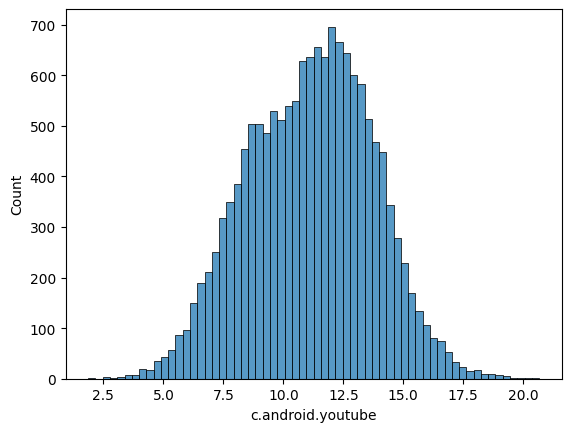

In [68]:
sns.histplot(connections_df['c.android.youtube'])

This data contains still contains outliers. For the rest of the solution we will use data from the previous part where outliers are handeled.

<Axes: xlabel='c.android.youtube', ylabel='Count'>

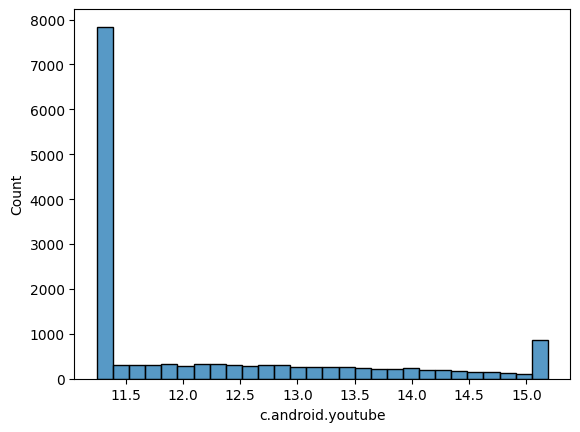

In [69]:
sns.histplot(rep_connections_df['c.android.youtube'])

Next we will split this data into two groups based on whether mwra is 1 or 0.

In [70]:
mwra_youtube = connections_df[rep_connections_df['mwra'] == 1 ]
nomwra_youtube = connections_df[rep_connections_df['mwra'] == 0]

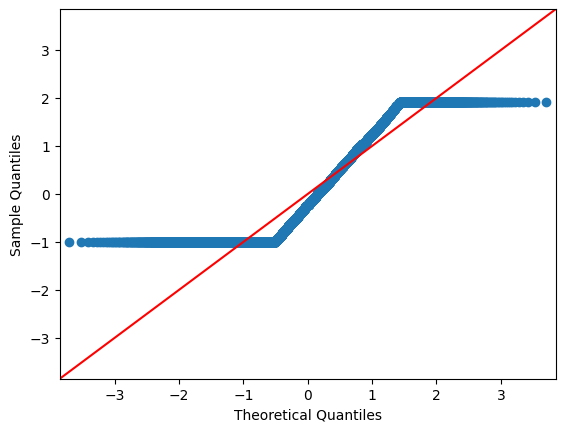

In [77]:
_ = sm.ProbPlot(mwra_youtube['c.android.youtube'], fit=True).qqplot(line='45')

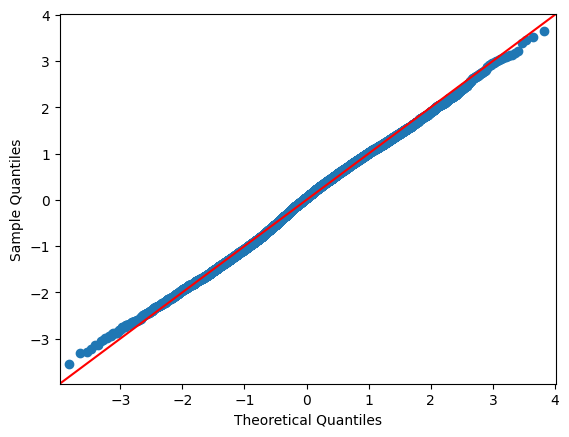

In [75]:
_ = sm.ProbPlot(connections_df['c.android.youtube'], fit=True).qqplot(line='45')

In [ ]:
stats.shapiro()

__Hypothesis 2:__ p.android.packageinstaller has on average a lower value when mwra is present